In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

In [7]:
df = pd.read_csv("/Users/chengling/Desktop/CS3244project-master/cleaned_data/complete_news_dataset_290920.csv", encoding='iso-8859-1')

df = df.drop(['Unnamed: 0'],axis = 1)

df.tail(5)

,text,label
5826,man wear secur uniform enter mall st cloud min...,1
5827,hillari top donor countri auction isi sex slav...,1
5828,clemson univ freshmen may longer public displa...,1
5829,k share share storyth senat reconven week demo...,0
5830,adverti stori continu belowon former presid bi...,1


In [11]:
df.isna().sum()

df.text.count()

#df.subject.value_counts()

#df['text'] = df['text'] + " " + df['title'] + " " 
#del df['title']
#del df['subject']
#del df['publish_date']

5831

In [68]:
## removing noisy words from text 
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [69]:
#stemming and lemmatization

stemmer = PorterStemmer()
def stem_text(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            word = stemmer.stem(i.strip())
            final_text.append(word)
    return " ".join(final_text)    

df.text = df.text.apply(stem_text)

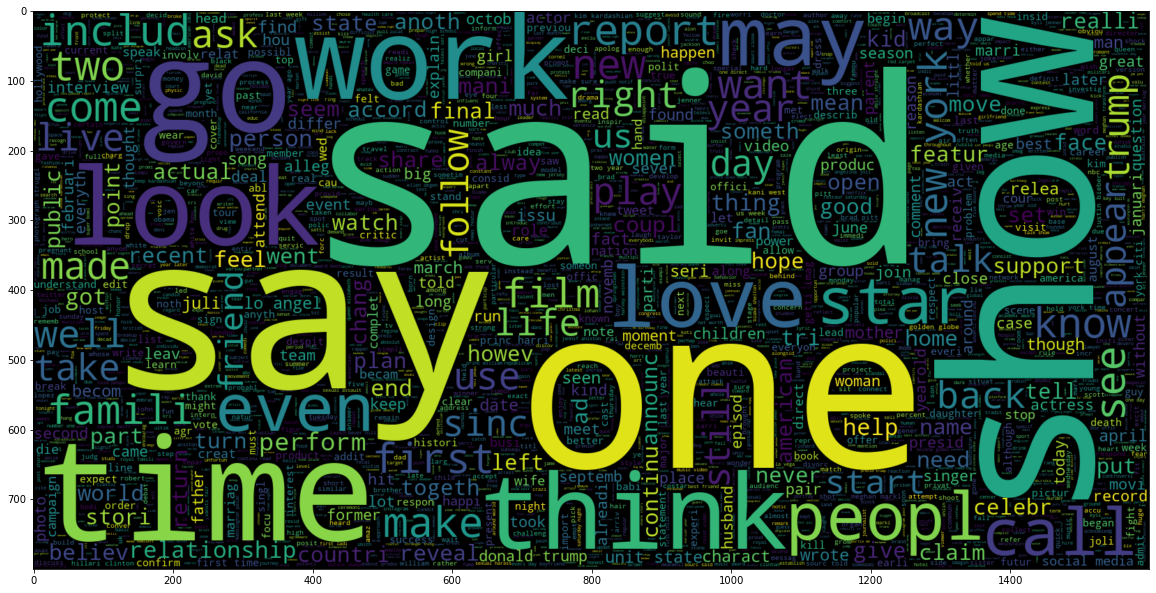

In [67]:
## Word Cloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df.text))
plt.imshow(wc , interpolation = 'bilinear')

In [80]:
##splitting training and testing data

x_train,x_test,y_train,y_test = train_test_split(df.text,df.label)
y_test = y_test.astype(float)

In [76]:
## Text to vector conversion

cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,2))
#transformed train reviews
cv_train_reviews=cv.fit_transform(x_train)
#transformed test reviews
cv_test_reviews=cv.transform(x_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (4373, 642340)
BOW_cv_test: (1458, 642340)


In [19]:
model = Sequential()
model.add(Dense(units = 100 , activation = 'relu' , input_dim = cv_train_reviews.shape[1]))
model.add(Dense(units = 50 , activation = 'relu'))
model.add(Dense(units = 25 , activation = 'relu'))
model.add(Dense(units = 10 , activation = 'relu'))
model.add(Dense(units = 1 , activation = 'sigmoid'))

In [74]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

ValueError: could not convert string to float: 'label'

In [71]:
model.fit(cv_train_reviews,y_train , epochs = 5)

ValueError: could not convert string to float: 'label'

In [25]:
pred = model.predict(cv_test_reviews)


array([[0.4998818 ],
       [0.500359  ],
       [0.5011096 ],
       ...,
       [0.5011814 ],
       [0.50002307],
       [0.4997932 ]], dtype=float32)

In [41]:
for i in range(len(pred)):
    if(pred[i] > 0.5):
        pred[i] = 1
    else:
        pred[i] = 0


In [42]:
accuracy_score(pred,y_test)

0.5116598079561042

In [43]:
cv_report = classification_report(y_test,pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.59      0.56      0.57       851
           1       0.42      0.45      0.43       607

    accuracy                           0.51      1458
   macro avg       0.50      0.50      0.50      1458
weighted avg       0.52      0.51      0.51      1458



In [44]:
cm_cv = confusion_matrix(y_test,pred)
cm_cv

array([[473, 378],
       [334, 273]])

In [45]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

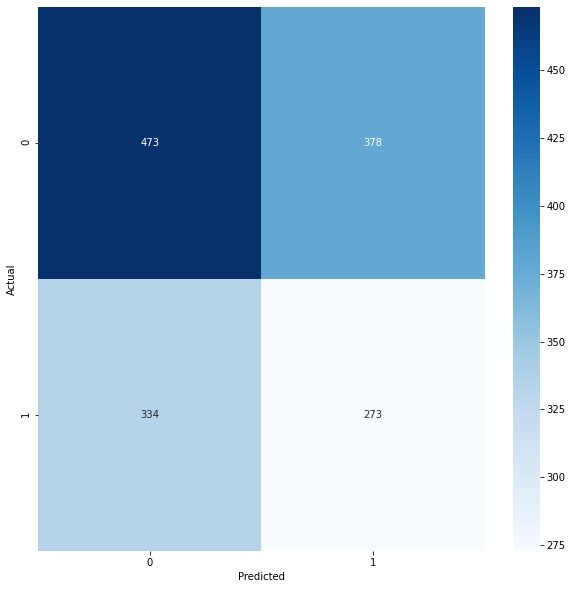

In [46]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')